In [1]:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

--2025-07-05 21:40:23--  https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.110.153, 185.199.109.153, 185.199.111.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4767 (4.7K) [application/x-sh]
Saving to: ‘/tmp/firedrake-install.sh’

/tmp/firedrake-inst 100%[===================>]   4.66K  --.-KB/s    in 0s      

2025-07-05 21:40:23 (44.4 MB/s) - ‘/tmp/firedrake-install.sh’ saved [4767/4767]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FIREDRAKE_INSTALLED=/usr/local/share/fem-on-colab/firedrake.installed
+ [[ ! -f /usr/local/share/fem-on-colab/firedrake.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/1df5

In [2]:
 from google.colab import drive
 drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from firedrake import *
import matplotlib.pyplot as plt
import numpy as np

from firedrake.petsc import PETSc

/tmp/ipython-input-4-1894416273.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left')


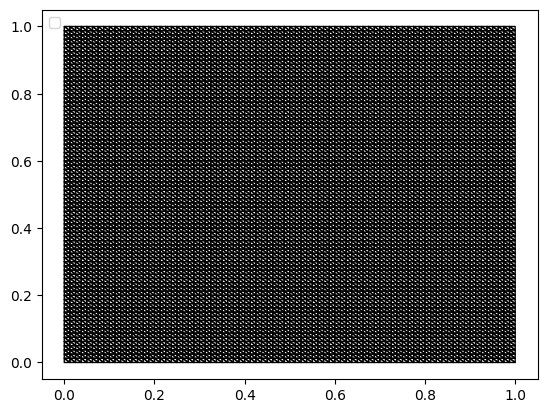

In [4]:
mesh = PeriodicUnitSquareMesh(80,80,direction="both")
fig, ax = plt.subplots()
triplot(mesh, axes=ax)
ax.legend(loc='upper left')

In [5]:
param = ( {'snes_type':'newtonls', # nonlinear solver types: https://petsc.org/release/manual/snes/#the-nonlinear-solvers
           'snes_linesearch_type':'bt',
            'snes_linesearch_monitor': None,         # mostra le info su ogni lambda provato
            'snes_linesearch_maxstep': 1.0,          # massimo valore di lambda (default è 1.0)
            'snes_linesearch_minlambda': 1e-3,       # lambda minimo accettato
            'snes_linesearch_damping': 1.0,
           'snes_monitor':'',        # activate logging options
           'snes_monitoring_lg_residualnorm':'', # print ||G|| at each iteration
           'snes_rtol':1e-4, 'snes_atol':1e-10, 'snes_stol':1e-14, 'snes_maxit':1000
          })

In [6]:
import numpy as np
from numpy.random import random



#Parameters
dt = 2.0e-02


mu=Constant(1) #scale 1e-4 diffusivity of FastNeutrons in Lead
nu=Constant(1e-5)
zeta=Constant(1e-4)


# Create mesh and finite element
P1 = FiniteElement("P", triangle, 1)
element = MixedElement([P1, P1,P1])
V = FunctionSpace(mesh, element)

triplot(mesh, axes=ax)


# Define variational problem
(v_1, v_2,v_3) = TestFunctions(V)

u_=Function(V) #new solution, time: n
u_1_,u_2_,u_3_=split(u_)

u_n =Function(V) #old solution, time: n-1
u_n1, u_n2,u_n3 =split(u_n)


#IC (random initializzation)
#component 0,1
n0 = u_.sub(0).dat.data.shape[0]
u_.sub(0).dat.data[:] = 0.1*np.random.rand(n0) - 0.1*np.random.rand(n0)
n1 = u_.sub(1).dat.data.shape[0]
u_.sub(1).dat.data[:] = 0.1*np.random.rand(n1) - 0.1*np.random.rand(n1)

#Tritium initial concentration: null
u_.sub(2).interpolate(Constant(1e-15))
u_n.assign(u_)


def non_linear_formulation(u_1,u_2,u_3,u_n1,u_n2,u_n3,v_1,v_2,v_3):
  u_1_, u_2_, u_3_ = split(u_)
  u_n1, u_n2, u_n3 = split(u_n)

  F  = 1/dt*inner((u_1-u_n1),v_1)*dx \
     +mu*inner(grad(u_1),grad(v_1))*dx\
     +1/dt*(u_2-u_n2)*v_2*dx\
     +nu*inner(grad(u_2),grad(v_2))*dx\
     +(-2*0.545*u_1  + 1.1*u_1*u_2 + 2.5*u_1 -u_1)*v_1*dx\
     +(1.1*u_1*u_2 )*v_2*dx\
     +1/dt*inner((u_3-u_n3),v_3)*dx \
     +zeta*inner(grad(u_3),grad(v_3))*dx\
     -(1.1*u_1*u_2)*v_3*dx\
     +1e-4*(pow(u_3,2))*v_3*dx
  return F

dwh=TrialFunction(V)
F=non_linear_formulation(u_1_,u_2_,u_3_,u_n1,u_n2,u_n3,v_1,v_2,v_3)
J=derivative(F,u_,dwh)
Form =NonlinearVariationalProblem(F,u_,J=J)
solver=NonlinearVariationalSolver(Form,solver_parameters=param)

t = 0.0
T=900*dt

#vtk initializzation
vtkfile_u_1 = File("/content/drive/MyDrive/4Test/pop1.pvd","compressed")
vtkfile_u_2 = File("/content/drive/MyDrive/4Test/pop2.pvd","compressed")
vtkfile_u_3 = File("/content/drive/MyDrive/4Test/pop3.pvd","compressed")


time_vec = np.arange(0, T, dt)  # endtime+0.1*dt to include also endtime: range/arange exclude the upper bound of the range


for ii in range(1, len(time_vec)):     # start from 1 to skip time=0
    t = time_vec[ii]
    print('Time = ', t)

    solver.solve()


    u_1_,u_2_,u_3_=u_.subfunctions
    u_n1, u_n2,u_n3=u_n.subfunctions


    u_1_.rename("pop_1")   # this name will be used in Paraview
    u_2_.rename("pop_2")
    u_3_.rename("pop_3")
    vtkfile_u_1.write(u_1_, time=t)
    vtkfile_u_2.write(u_2_, time=t)
    vtkfile_u_3.write(u_3_, time=t)


    u_n1.assign(u_1_)
    u_n2.assign(u_2_)
    u_n3.assign(u_3_)

/usr/local/lib/python3.11/dist-packages/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(


Time =  0.02
  0 SNES Function norm 1.469854972523e+01
      Line search: Scaling step by 3.076276306774e-01 old ynorm 3.250683294599e+00
      Line search: Using full step: fnorm 1.469854972523e+01 gnorm 1.017686969895e+01
  1 SNES Function norm 1.017686969895e+01
      Line search: Scaling step by 4.443095140805e-01 old ynorm 2.250683292410e+00
      Line search: Using full step: fnorm 1.017686969895e+01 gnorm 5.655189668227e+00
  2 SNES Function norm 5.655189668227e+00
      Line search: Scaling step by 7.995629325476e-01 old ynorm 1.250683291200e+00
      Line search: Using full step: fnorm 5.655189668227e+00 gnorm 1.133509633068e+00
  3 SNES Function norm 1.133509633068e+00
      Line search: Using full step: fnorm 1.133509633068e+00 gnorm 9.572890393551e-10
  4 SNES Function norm 9.572890393551e-10
Time =  0.04
  0 SNES Function norm 1.354542118091e-02
      Line search: Using full step: fnorm 1.354542118091e-02 gnorm 2.888755182090e-09
  1 SNES Function norm 2.888755182090e-09
T

Text(0.5, 1.0, 'population')

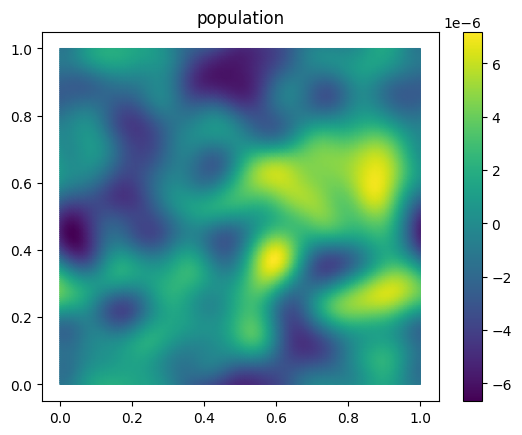

In [10]:
fig, ax = plt.subplots()
col = tripcolor(u_3_, axes=ax)
plt.colorbar(col)
plt.title('population')